In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
import argparse
import logging
import shutil
import re
import pickle
from PIL import Image
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim
from torchvision.datasets import VisionDataset
from torchvision import transforms
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

from utils import *
from auto_tqdm import tqdm
import augmentations
%matplotlib inline

# Pending the masks for the agglomerated slides (see function below)

Read data

In [4]:
import sys
sys.path.append("../clinical_data_classifier")
from rtog_helper import rtog_from_study_number

def gleason_isup(primary, secondary):
    if primary + secondary in {9,10}:
        return 5
    elif primary + secondary == 8:
        return 4
    elif primary == 4.0 and secondary == 3.0:
        return 3
    elif primary == 3.0 and secondary == 4.0:
        return 2
    elif primary + secondary <= 6.0:
        return 1
    else: # catchall for unknown
        return 0

def load_quilts(directory, df):
    """Loads features, images, and isup score
    
    Args:
        directory(str): folder contained entries of the form '[caseid]_quilt.tiff' and '[caseid]_quilt_feature.pkl'
        df(Dataframe): Reference dataframe with gleason primary/secondary for a given case id. 
            Load using rtog_from_study_number(rtog_num)
    
    Returns tuple of the form:
        (cn_deid, feature_quilt_paths, image_quilt_paths, isup_score)
    """
    feature_quilt_paths = sorted([os.path.join(directory,i) for i in os.listdir(directory) if '.pkl' in i])
    image_quilt_paths = sorted([os.path.join(directory,i) for i in os.listdir(directory) if '.tiff' in i])
    cn_deids = np.array([int(i.split("/")[-1].split('_')[0]) for i in feature_quilt_paths])
    
    primary_from_cndeid = lambda x: df.loc[df['cn_deidentified'] == x, 'gleason_primary'].values[0]
    primary = [primary_from_cndeid(i) for i in cn_deids]

    if 'gleason_secondary' in df.keys():
        secondary_from_cndeid = lambda x: df.loc[df['cn_deidentified'] == x, 'gleason_secondary'].values[0]
        secondary = [secondary_from_cndeid(i) for i in cn_deids]
    else: #have gleason combined
        secondary_from_cndeid = lambda x: df.loc[df['cn_deidentified'] == x, 'gleason_combined'].values[0] - df.loc[df['cn_deidentified'] == x, 'gleason_primary'].values[0]
        secondary = [secondary_from_cndeid(i) for i in cn_deids]

    isup = [gleason_isup(p, s) for p, s in zip(primary, secondary)]
    df['isup'] = np.nan
    for c, i in zip(cn_deids, isup):
        df.loc[df['cn_deidentified'] == c, 'isup'] = i
    
    return cn_deids, feature_quilt_paths, image_quilt_paths, isup, df


X = []
X_images = []
y = []
new_dfs = {}
for sn in ['9202', '9413', '9408']:
#     sn_path = "/export/medical_ai/ucsf/simclr_rtog/model_simclr/checkpoint_110/RTOG_{}_simclr/".format(sn)
#     sn_path = "/export/medical_ai/ucsf/simclr_rtog/model_simclr/checkpoint_210/features_and_quilts/{}_quilts/".format(sn)
#     sn_path = "/export/medical_ai/ucsf/simclr_rtog/model_simclr_gp4plus/checkpoint_70/features_and_quilts/{}_quilts/".format(sn)
#     sn_path = "/export/medical_ai/ucsf/simclr_rtog/imagenet_data/model_resnet50_2x_sk_supervised/{}_quilts/".format(sn)
    sn_path = "/export/medical_ai/ucsf/simclr_rtog/model_resnet50_gp4plus_pretrained_lr=0.0005/features/RTOG_{}_quilts/".format(sn)
    cn_deids, feature_quilt_paths, image_quilt_paths, isup, df = load_quilts(sn_path, rtog_from_study_number(sn).df)
    new_dfs[sn] = df
    check_name = lambda u, v: u.split('/')[-1].split('_')[0] == v.split('/')[-1].split('_')[0]
    for f, i in zip(feature_quilt_paths, image_quilt_paths):
        assert check_name(f,i), 'mismatch {} {}'.format(f,i)
    print("Loaded {} from {}".format(len(feature_quilt_paths), sn_path))
    X.extend(feature_quilt_paths)
    X_images.extend(image_quilt_paths)
    y.extend(isup)
X = np.array(X)
y = np.array(y)

for i in range(6):
    print("Class {} has {} data points".format(i, np.sum(y == i)))
print("{} Total Data Points".format(len(y)))


Loaded 630 from /export/medical_ai/ucsf/simclr_rtog/model_resnet50_gp4plus_pretrained_lr=0.0005/features/RTOG_9202_quilts/
Loaded 625 from /export/medical_ai/ucsf/simclr_rtog/model_resnet50_gp4plus_pretrained_lr=0.0005/features/RTOG_9413_quilts/
Loaded 739 from /export/medical_ai/ucsf/simclr_rtog/model_resnet50_gp4plus_pretrained_lr=0.0005/features/RTOG_9408_quilts/
Class 0 has 107 data points
Class 1 has 854 data points
Class 2 has 425 data points
Class 3 has 237 data points
Class 4 has 220 data points
Class 5 has 151 data points
1994 Total Data Points


In [5]:
# Sanity Check
new_dfs['9202'][['cn_deidentified', 'gleason_primary', 'gleason_secondary', 'isup']][:50]
new_dfs['9408'][['cn_deidentified', 'gleason_primary', 'gleason_secondary', 'isup']][:50]
new_dfs['9413'][['cn_deidentified', 'gleason_primary', 'gleason_combined', 'isup']][:50]

,cn_deidentified,gleason_primary,gleason_combined,isup
0,1,5.0,9,5.0
1,2,3.0,7,2.0
2,3,4.0,7,NaN
3,4,3.0,6,1.0
4,5,4.0,7,NaN
5,6,3.0,6,NaN
6,7,NaN,6,NaN
7,8,5.0,9,NaN
8,9,4.0,7,3.0
9,10,3.0,7,2.0


In [6]:
from histopathology_image_helper import CaseManager
cm = CaseManager()

In [13]:
X[i]
# int(X[i].split('/')[-1].split('_')[0])
# X[i].split('/')[-2].split('_')[0]

'/export/medical_ai/ucsf/simclr_rtog/model_resnet50_gp4plus_pretrained_lr=0.0005/features/RTOG_9413_quilts/497_quilt_feature.pkl'

/export/medical_ai/ucsf/simclr_rtog/model_resnet50_gp4plus_pretrained_lr=0.0005/features/RTOG_9202_quilts/1361_quilt_feature.pkl
Gleason_primary=2.0
Label=1


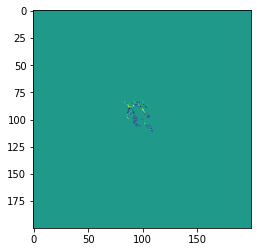

In [14]:
# Check that image and feature blocks match
def display_quilt_feature(feature_quilt_path):
    feature_quilt = pickle.load(open(feature_quilt_path, 'rb'))
    feature_quilt = torch.Tensor(feature_quilt.transpose((2,0,1)))
#     plt.figure(figsize=(10,10))
    plt.imshow(np.mean(feature_quilt.cpu().numpy(), axis=0))
    plt.show()

def display_quilt_image(image_quilt_path):
    im = Image.open(image_quilt_path)
    return im.resize((300,300))

i = np.random.choice(len(X))
print(X[i])
# print(X_images[i])
print("Gleason_primary={}".format(
    cm.get_feature_by_case('gleason_primary',
                           int(X[i].split('/')[-1].split('_')[0]),
                           X[i].split('/')[-2].split('_')[1]
                          ),
))
print("Label={}".format(y[i]))
display_quilt_feature(X[i]); 
# im = display_quilt_image(X_images[i]); 
# im

In [6]:
new_dfs['9413'][new_dfs['9413']['cn_deidentified'] == 180]['gleason_primary']

179    3.0
Name: gleason_primary, dtype: float64

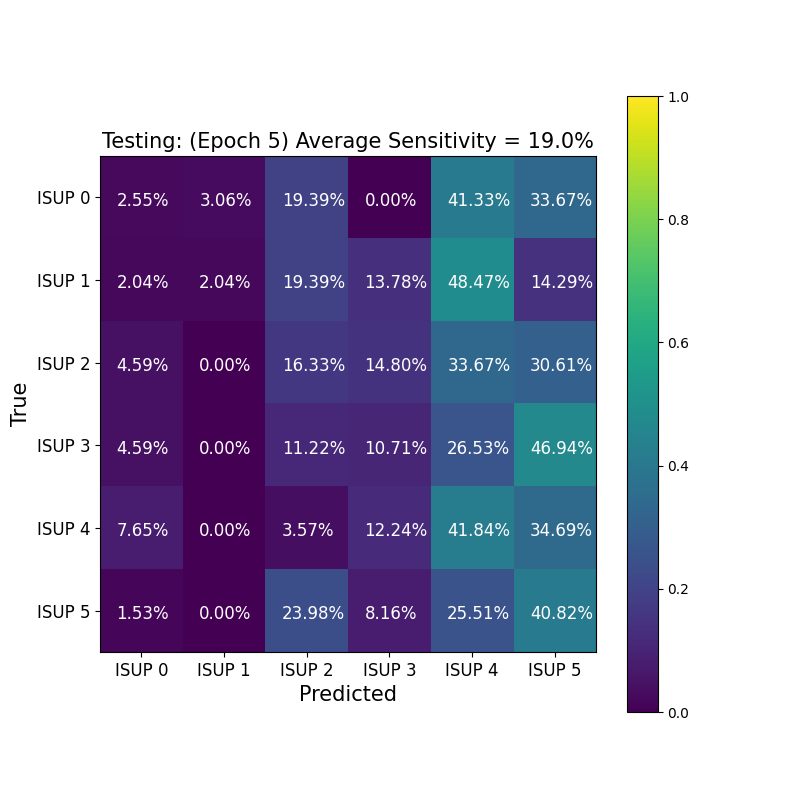

In [15]:
from PIL import Image
# Image.open("./plot_cm/Testing: _epoch=0_AvgSens=16.666666666666668.png")
# Image.open("./plot_cm/Training: _epoch=0_AvgSens=16.666666666666668.png")
Image.open("./plot_cm/imagenet_features/resnet50_2x_sk_supervised/Testing_epoch=5_AvgSens=19.047619047619047.png")
# Image.open("./plot_cm/imagenet_features/resnet50_2x_sk_supervised/Training_epoch=5_AvgSens=24.631519274376416.png")

# Image.open("./plot_cm/imagenet_features/resnet50_2x_sk_supervised_lr=0.0003/Testing_epoch=5_AvgSens=17.036077130416754.png")

In [15]:
cudnn.benchmark = True
use_cuda = torch.cuda.is_available()
device = torch.device('cuda') if use_cuda else 'cpu'

Create slide-level dataset

In [16]:
from sklearn.model_selection import train_test_split
from utils import balanced_dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

print("Train:")
for i in range(6):
    print("Class {} has {} data points".format(i, np.sum(y_train == i)))
print()
print("Test:")
for i in range(6):
    print("Class {} has {} data points".format(i, np.sum(y_test == i)))
    
X_train, y_train = balanced_dataset(X_train, y_train, min_size=np.max(np.unique(y_train, return_counts=True)) * 6)
X_test, y_test = balanced_dataset(X_test, y_test, min_size=np.max(np.unique(y_test, return_counts=True)) * 6)


Train:
Class 0 has 80 data points
Class 1 has 640 data points
Class 2 has 319 data points
Class 3 has 178 data points
Class 4 has 165 data points
Class 5 has 113 data points

Test:
Class 0 has 27 data points
Class 1 has 214 data points
Class 2 has 106 data points
Class 3 has 59 data points
Class 4 has 55 data points
Class 5 has 38 data points


Slide-level ConvNet

In [9]:
class RegionShuffle(object):
    """Retiles the given feature block by randomly shuffling its contiguous regions of size h x w
    h = H x region_fraction
    w = W x region_fraction
    H is the image height
    W is the image width
    Works for any number of channels
    """
    def __init__(self, region_fraction=0.20):
        assert region_fraction > 0
        assert region_fraction <= 1
        self.region_fraction = region_fraction
    
    def __call__(self, array):
        assert len(array.shape) == 3 # assume H X W X C
        H, W = array.shape[0], array.shape[1]
        h = int(H * self.region_fraction)
        w = int(W * self.region_fraction)
        regions = []
        for i in range(H // h):
            for j in range(W // w):
                r = array[h * i:h*(i+1), w*j:w*(j+1), :]
                regions.append(r)
        np.random.shuffle(regions)
        for i in range(H // h):
            for j in range(W // w):
#                 print("h={},i={}|w={},j={}".format(h,i,w,j))
                r = regions[i*(W // w) + j]
                array[h * i:h*(i+1), w*j:w*(j+1), :] = r
        return array
        
        

In [17]:
from sklearn.metrics import confusion_matrix

class CustomDataset(VisionDataset):
    
    def __init__(self, X, y, transform=None, use_cache=True, max_cache_size=np.inf):
        
        super(CustomDataset, self).__init__('', transform=transform)
        self.X = X
        self.y = y
        self.use_cache = use_cache
        self._cache = {}
        self.transform = transform
        self.max_cache_size = max_cache_size
        assert len(self.X) == len(self.y)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        feature_quilt_path, target = self.X[index], self.y[index]
        if self.use_cache and len(self._cache) < self.max_cache_size:
            if feature_quilt_path in self._cache:
                feature_quilt = self._cache[feature_quilt_path]
            else:
                feature_quilt = pickle.load(open(feature_quilt_path, 'rb'))
                self._cache[feature_quilt_path] = feature_quilt
        else:
            feature_quilt = pickle.load(open(feature_quilt_path, 'rb'))

        if self.transform is not None:
            feature_quilt = self.transform(feature_quilt)
        
        feature_quilt = torch.Tensor(feature_quilt.transpose((2,0,1)))
        return feature_quilt, target
    
    def extra_repr(self):
        return "CustomDataset: use_cache={}, max_cache_size={}. Split: {}".format(
            self.use_cache,
            self.max_cache_size,
            "Train" if self.train is True else "Test",
        )

    
def train(device, model, train_loader, optimizer, epoch):
    
    model.train()
    train_metrics = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        logits = model(data)
        loss = F.cross_entropy(logits, target)
        loss.backward()
        optimizer.step()
        
        train_metrics.append(dict(
            epoch=epoch,
            loss=loss.item()))
        if batch_idx % 10 == 0:
            print(
                'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader) * batch_size,
                           100. * batch_idx / len(train_loader), loss.item()))
    return train_metrics


class ConvLayer(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride=1):

        super().__init__()
        self.conv = torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                                    stride=stride)
        self.bn = torch.nn.BatchNorm2d(out_channels)
        self.relu = torch.nn.ReLU(inplace=True)

    def forward(self, x):

        h = self.conv(x)
        h = self.bn(h)
        h = self.relu(h)
        return h
    

class MiniModel(nn.Module):

    def __init__(self, num_classes):

        super().__init__()
        self.cl1_1 = ConvLayer(128, 128, 3, 1)
        self.cl1_2 = ConvLayer(128, 128, 3, 1)
        self.cl2_1 = ConvLayer(128, 128, 3, 1)
        self.cl2_2 = ConvLayer(128, 128, 3, 1)
        self.cl3_1 = ConvLayer(128, 128, 3, 1)
        self.cl3_2 = ConvLayer(128, 128, 3, 1)
        self.fc = torch.nn.Linear(128, num_classes)


    def forward(self, x):

        h = self.cl1_1(x)
        h = self.cl1_2(h)
        h = torch.nn.MaxPool2d(3, 3)(h)
        h = self.cl2_1(h)
        h = self.cl2_2(h)
        h = torch.nn.MaxPool2d(3, 3)(h)
        h = self.cl3_1(h)
        h = self.cl3_2(h)
        h = torch.nn.MaxPool2d(3, 3)(h)
        h = torch.mean(h, axis=(-1, -2))
        return self.fc(h)
    
    
class NanoModel3(nn.Module):

    def __init__(self, num_classes):

        super().__init__()
        self.cl1_1 = ConvLayer(128, 1, 3, 1)
#         self.cl1_2 = ConvLayer(128, 128, 3, 1)
        self.fc = torch.nn.Linear(198 * 198, num_classes)

    def forward(self, x):

        h = self.cl1_1(x)
#         h = self.cl1_2(h)
#         h = torch.nn.MaxPool2d(3, 3)(h)
        h = h.view((len(h),-1,))
#         h = torch.mean(h, axis=(-1, -2))
        return self.fc(h)
    
    
class NanoModel2(nn.Module):

    def __init__(self, num_classes, n_input_features=128):

        super().__init__()
        self.cl1_1 = ConvLayer(n_input_features, 128, 3, 1)
        self.cl1_2 = ConvLayer(128, 128, 3, 1)
        self.fc = torch.nn.Linear(128, num_classes)

    def forward(self, x):

        h = self.cl1_1(x)
        h = self.cl1_2(h)
        h = torch.nn.MaxPool2d(3, 3)(h)
        h = torch.mean(h, axis=(-1, -2))
        return self.fc(h)
    
    
class NanoModel(nn.Module):

    def __init__(self, num_classes):

        super().__init__()
        self.cl1_1 = ConvLayer(128, 64, 3, 1)
        self.cl1_2 = ConvLayer(64, 32, 3, 1)
        self.cl2_1 = ConvLayer(32, 16, 3, 1)
        self.cl2_2 = ConvLayer(16, 1, 3, 1)
        self.fc200 = torch.nn.Linear(20 * 20, num_classes)

    def forward(self, x):
        h = self.cl1_1(x)
        h = self.cl1_2(h)
        h = torch.nn.MaxPool2d(3, 3)(h)
        h = self.cl2_1(h)
        h = self.cl2_2(h)
        h = torch.nn.MaxPool2d(3, 3)(h)
        h = h.view(-1, 1 * 20 * 20)
        return self.fc200(h)
    

class MLP(nn.Module):
    
    def __init__(self, num_classes):
        
        super().__init__()
        self.fc1 = torch.nn.Linear(128 * 200 * 200, 4000)
        self.fc2 = torch.nn.Linear(4000, 200)
        self.fc3 = torch.nn.Linear(200, num_classes)
        self.relu = torch.nn.ReLU(inplace=True)
        
    def forward(x):
        h = self.fc1(x)
        h = self.relu(h)
        h = self.fc2(h)
        h = self.relu(h)
        h = self.fc3(h)
        
    
    
def plot_confusion_matrix(true, predicted, title_prefix=""):
    fig = plt.figure(figsize=(8, 8))
    cm = confusion_matrix(np.concatenate(true), np.concatenate(predicted))
    normalized_cm = cm/np.sum(cm, -1, keepdims=True)
    plt.imshow(normalized_cm, vmin=0., vmax=1)
    plt.imshow(normalized_cm, vmin=0., vmax=1)
    plt.colorbar()
    plt.xticks(np.arange(6), ['ISUP {}'.format(i) for i in range(6)], fontsize=12)
    plt.yticks(np.arange(6), ['ISUP {}'.format(i) for i in range(6)], fontsize=12)
    plt.xlabel('Predicted', fontsize=15)
    plt.ylabel('True', fontsize=15)
    true = np.concatenate(true)
    predicted = np.concatenate(predicted)
    sensitivities = []
    for val in np.unique(true):
        s = 100 * np.mean( true[true == val] == predicted[true == val] )
        sensitivities.append(s)
    if title_prefix:
        title_prefix += ": "
    plt.title('{0} Average Sensitivity = {1:.1f}%'.format(
            title_prefix,
            np.mean(sensitivities)
            ),
            fontsize=15)
#     plt.title('{0} Prediction Accuracy = {1:.1f}%'.format(
#         title_prefix,
#         100 * np.mean(np.concatenate(true) == np.concatenate(predicted))
#     ), fontsize=15)
    for i in range(6):
        for j in range(6):
            plt.annotate('{0:.2f}%'.format(100 * normalized_cm[i, j]), (j-0.3, i+0.1), color='white', fontsize=12)

    plt.show()
    return np.mean(sensitivities)
    
    
def predict_all(model, dataloader):
    model.eval()
    true, predicted = [], []
    for batch_idx, (data, target) in tqdm(enumerate(dataloader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        logits = model(data)
        predicted.append(logits.argmax(-1).detach().cpu().numpy())
        true.append(target.detach().cpu().numpy())
    return predicted, true

In [18]:
batch_size = 32

In [19]:
train_dataset = CustomDataset(X_train, y_train, use_cache=True)#, transform=RegionShuffle())
test_dataset = CustomDataset(X_test, y_test, use_cache=True)
kwargs = {'num_workers': 12, 'pin_memory': False} if use_cuda else {}
kwargs = {}
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, **kwargs)
test_loader =  DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

In [ ]:
# model = MiniModel(num_classes=6)
# model = NanoModel(num_classes=6)
model = NanoModel2(num_classes=6, n_input_features=128)
# model = NanoModel3(num_classes=6)
# model = MLP(num_classes=6)
if use_cuda:
    model = torch.nn.DataParallel(model).cuda()
    
# Optimizers on Torch: https://pytorch.org/docs/stable/optim.html

# optimizer = optim.SGD(model.parameters(), lr=0.00001,
#                       momentum=0.9,
#                       weight_decay=5e-4,
#                       nesterov=True)

# 3/10000 - good lr for deep models ("karpathy constant")

optimizer = optim.Adam(model.parameters(), 
                       lr=0.000005,
                       weight_decay=5e-2,
                       amsgrad=False)

In [ ]:
for epoch in range(0, 100):
    if epoch % 5 == 0:
        # Validation Accuracy and CM
        predicted, true = predict_all(model, test_loader)
        average_sensitivity = plot_confusion_matrix(true, predicted, title_prefix="Testing")
        print("Validation: Average Sensitivity {}".format(average_sensitivity))
                
        # Training Accuracy and CM
        predicted, true = predict_all(model, train_loader)
        average_sensitivity = plot_confusion_matrix(true, predicted, title_prefix="Training")
        print("Training: Average Sensitivity {}".format(average_sensitivity))
    
    lr = 0.0003 * 0.5 * (1 + np.cos((epoch - 1) / 200 * np.pi))
    print('Setting learning rate to %g' % lr)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    train(device, model, train_loader, optimizer, epoch)

In [ ]:
# from sklearn.metrics import confusion_matrix

# predicted, true = predict_all(model, test_loader)
# plot_confusion_matrix(true, predicted)

Channel 0
Train Data


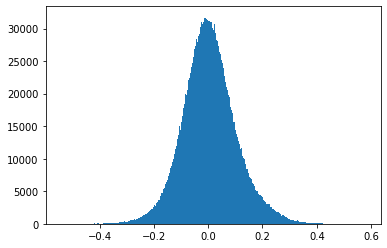

Test Data


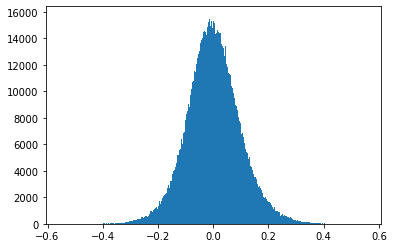

In [21]:
# Check histogram of channels for train vs test data

test_tensors = []
for t in tqdm(test_dataset):
    test_tensors.append(t[0])
    
train_tensors = []
for t in tqdm(train_dataset):
    train_tensors.append(t[0])

import matplotlib.pyplot as plt
channel = 0

print("Channel {}".format(channel))

print("Train Data")
channel_data = [t[channel].unsqueeze(0).cpu().numpy() for t in train_tensors]
channel_data = np.concatenate(channel_data, axis=0)
channel_data = channel_data.reshape(-1,1)
channel_data = channel_data[channel_data != 0]
plt.hist(channel_data.reshape(-1,1), bins='auto')
plt.show()

print("Test Data")
channel_data = [t[channel].unsqueeze(0).cpu().numpy() for t in test_tensors]
channel_data = np.concatenate(channel_data, axis=0)
channel_data = channel_data.reshape(-1,1)
channel_data = channel_data[channel_data != 0]
plt.hist(channel_data.reshape(-1,1), bins='auto')
plt.show()